In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MLP, NRE
from criterions import WeightedLoss, RELoss
from samplers import TractableSampler, NRESampler
from histograms import pairhist, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([ 0.1535, -2.8693,  1.6482, -1.9718, -2.8688], device='cuda:0'),
 tensor([[ 2.5500e+00, -6.0527e+00],
         [ 5.1220e-04, -3.0923e+00],
         [-2.3458e+00,  8.9358e-01],
         [ 3.4654e+00, -7.8783e+00]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator)

## Model

In [7]:
encoder = Flatten((4, 2)).to(device)
model = NRE(5, 8, num_layers=10, hidden_size=512, activation=nn.SELU).to(device)
criterion = RELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

### Train

In [8]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, encoder(xs))
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

torch.save(model.state_dict(), 'nre.pth')

0: 0.6445736885070801 +- 0.19838537275791168
1: 0.4854486584663391 +- 0.24691005051136017
2: 0.3967078626155853 +- 0.1766464114189148
3: 0.37685298919677734 +- 0.24323678016662598
4: 0.30026769638061523 +- 0.11371053755283356
5: 0.25379523634910583 +- 0.10802660882472992
6: 0.20915240049362183 +- 0.11810464411973953
7: 0.16463914513587952 +- 0.06930354982614517
8: 0.14327719807624817 +- 0.06282811611890793
9: 0.131529301404953 +- 0.05231620371341705
10: 0.12781749665737152 +- 0.057525452226400375
11: 0.12055861949920654 +- 0.04750877991318703
12: 0.11638043820858002 +- 0.04801873862743378
13: 0.11270943284034729 +- 0.04503573849797249
14: 0.10731242597103119 +- 0.04201505333185196
15: 0.10693632811307907 +- 0.04483485594391823
16: 0.10164154320955276 +- 0.043982766568660736
17: 0.09789807349443436 +- 0.041340578347444534
18: 0.09739410132169724 +- 0.039999037981033325
19: 0.09649551659822464 +- 0.040687721222639084
20: 0.0986279845237732 +- 0.04012653976678848
21: 0.09234307706356049 +

In [9]:
# model.load_state_dict(torch.load('nre.pth', map_location=device))

## Metropolis-Hastings

In [10]:
low = simulator.low.cpu()
high = simulator.high.cpu()

In [11]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

In [12]:
x_star = x_star.expand(2 ** 12, -1, -1)

### Likelihood

In [13]:
sampler = TractableSampler(simulator, x_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low, high, bins=60, normed=True, bounded=True)

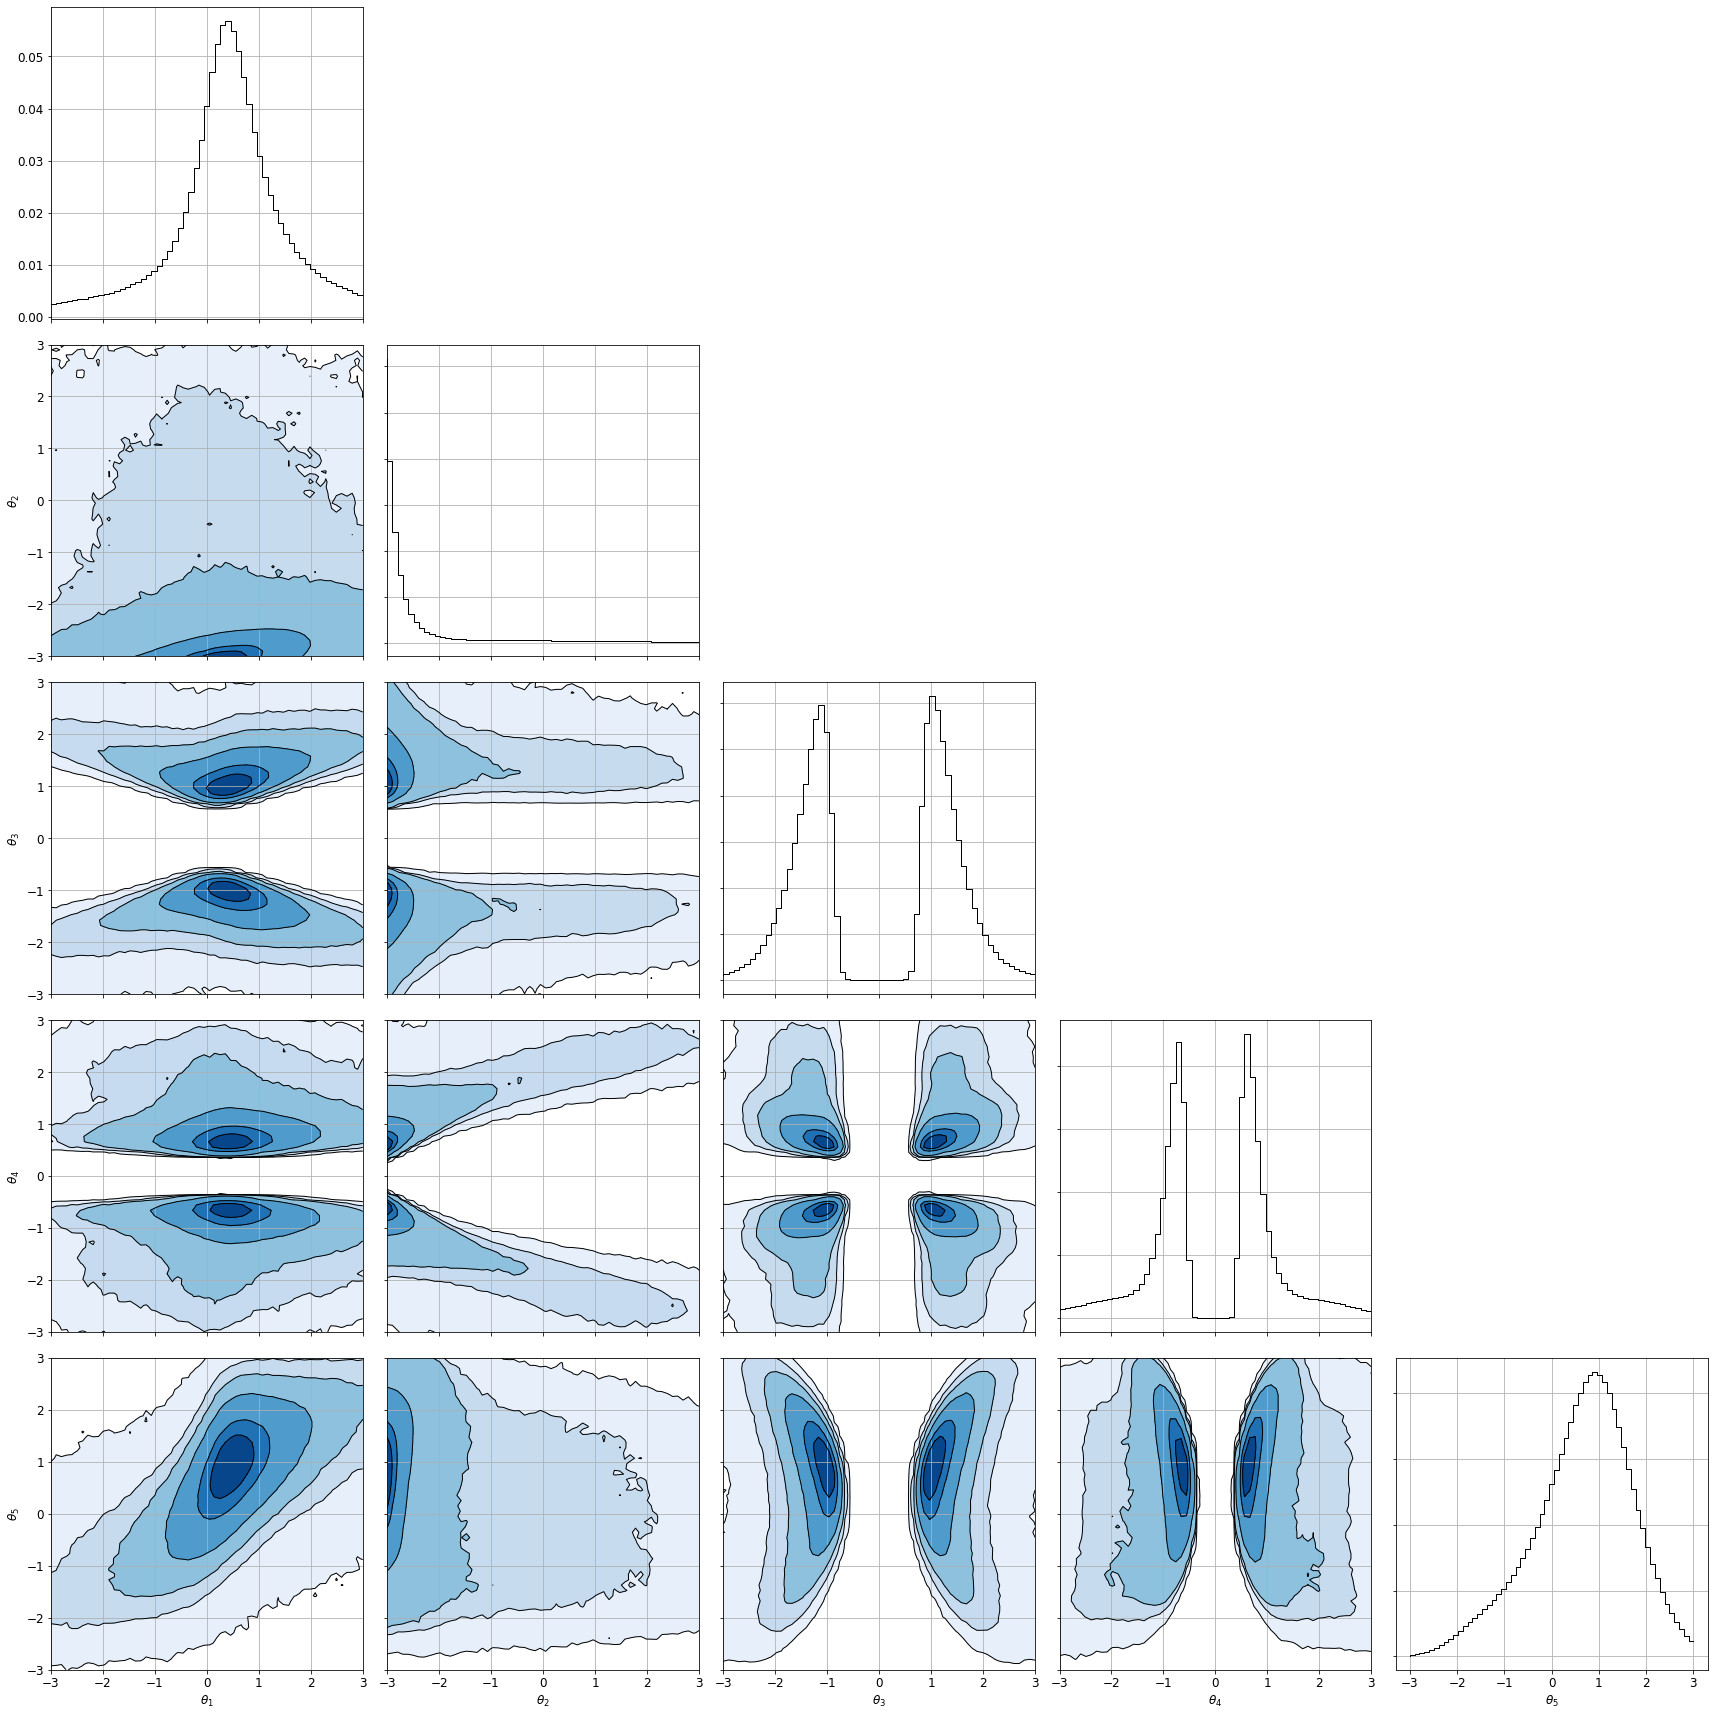

In [14]:
labels = [f'$\\theta_{{{i}}}$' for i in range(1, 6)]
fig = corner(hists, low, high, labels=labels)

### NRE

In [15]:
model.eval()
z_star = encoder(x_star)

In [16]:
sampler = NRESampler(simulator.prior, model, z_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low, high, bins=60, normed=True, bounded=True)

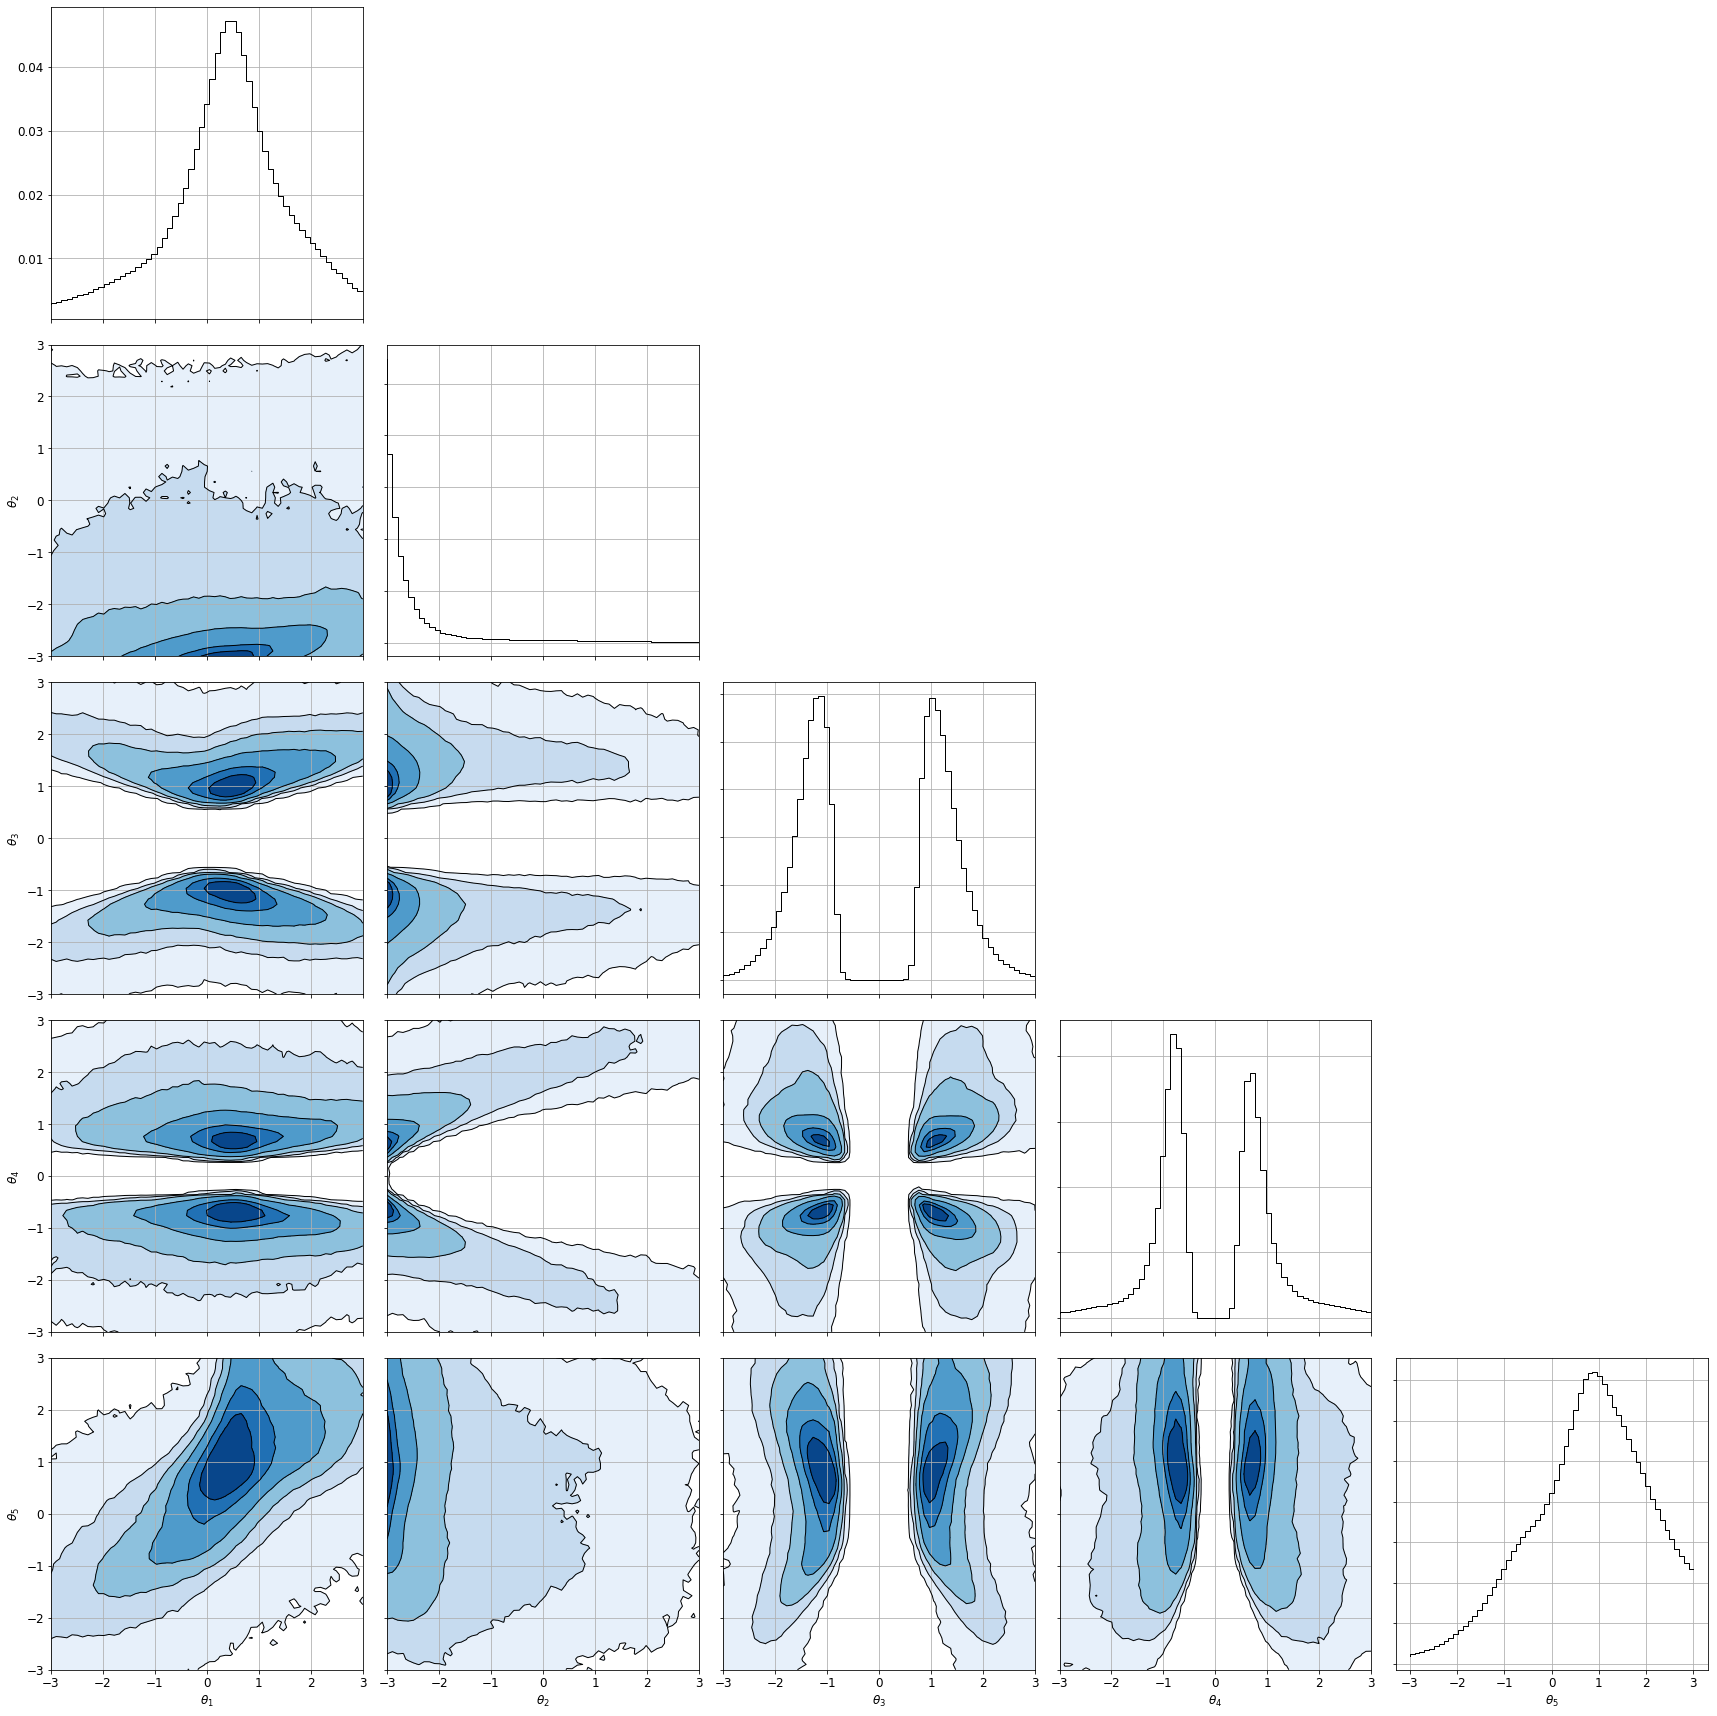

In [17]:
fig = corner(hists, low, high, labels=labels)